## Exploring the CIFAR10 Dataset

In the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we trained a feedfoward neural networks with a single hidden layer to classify handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist) with over 97% accuracy. For this tutorial, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Here are some sample images from the dataset:

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as OPT
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import os
import matplotlib.pyplot as plt

The dataset contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [2]:
classes = os.listdir("Datasets/cifar10/train")
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's look inside a couple of folders, one from the training set and another from the test set.

In [3]:
for class_name in classes:
    nums = len(os.listdir(f"Datasets/cifar10/train/{class_name}"))
    print(f"Number of {class_name}s: {nums}")
    
print("Test sample:", os.listdir("Datasets/cifar10/train/bird")[:5])

Number of airplanes: 5000
Number of automobiles: 5000
Number of birds: 5000
Number of cats: 5000
Number of deers: 5000
Number of dogs: 5000
Number of frogs: 5000
Number of horses: 5000
Number of ships: 5000
Number of trucks: 5000
Test sample: ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [4]:
dataset = ImageFolder("Datasets/cifar10/train", transform=ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

In [5]:
image, label_index = dataset[0]
print(image.shape)
print(classes[label_index])
print(image)

torch.Size([3, 32, 32])
airplane
tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157,

The list of classes is stored in the `.classes` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [6]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We can view the image using `matplotlib`, but we need to change the tensor dimensions to `(32,32,3)`. Let's create a helper function to display an image and its label.

In [7]:
def show_example(image, label):
    print(f"Label: {dataset.classes[label]} ({label})")
    plt.imshow(image.permute(1, 2, 0))

Let's look at a couple of images from the dataset. As you can tell, the 32x32px images are quite difficult to identify, even for the human eye. Try changing the indices below to view different images.

Label: airplane (0)


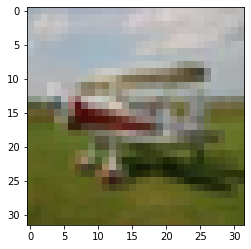

In [8]:
show_example(*dataset[9])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [9]:
valid_size = 5_000
train_size = len(dataset) - valid_size
batch_size = 64

train_ds, valid_ds = random_split(dataset, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

## Defining the Model (Convolutional Neural Network)

In our [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we defined a deep neural network with fully-connected layers using `nn.Linear`. For this tutorial however, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [10]:
""" Remains the kernel shape """
def apply_kernel(image, kernel):
    rows_img, columns_img = image.shape
    rows_ker, columns_ker = kernel.shape
    output_rows = rows_img - rows_ker + 1
    output_cols = columns_img - columns_ker + 1
    output = torch.zeros([output_rows, output_cols])
    
    for i in range(output_rows): 
        for j in range(output_cols):
            output[i,j] = torch.sum(image[i:i+rows_ker,j:j+columns_ker] * kernel)
    return output

In [11]:
sample_image = torch.tensor([
                            [3, 3, 2, 1, 0], 
                            [0, 0, 1, 3, 1], 
                            [3, 1, 2, 2, 3], 
                            [2, 0, 0, 2, 2], 
                            [2, 0, 0, 0, 1]
                            ])
sample_kernel = torch.tensor([
                             [0, 1, 2], 
                             [2, 2, 0], 
                             [0, 1, 2]
                             ])

out = apply_kernel(sample_image, sample_kernel)
print(out)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])


For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [12]:
""" Channels, Output Channels """
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [13]:
for images, labels in train_dl:
    print(images.shape)
    out = simple_model(images)
    print(out.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [14]:
def accuracy(model_outputs, actual_outputs):
    _, preds = torch.max(model_outputs, dim=1)
    return (preds == actual_outputs).sum().item() / preds.numel()

In [17]:
class ImageClassificationBase(nn.Module):
    def training_step(self, training_batch):
        input_batch, output_batch = training_batch
        outputs = self(input_batch)
        loss = F.cross_entropy(outputs, output_batch)
        return loss
    
    def validation_step(self, validation_batch):
        input_batch, output_batch = validation_batch
        outputs = self(input_batch)
        loss = F.cross_entropy(outputs, output_batch).item()
        acc = accuracy(outputs, output_batch)
        return {"valid_batch_loss": loss, "valid_batch_acc": acc}
    
    def validation_end(self, valid_batches_results):
        avg_loss = torch.tensor([x["valid_batch_loss"] for x in valid_batches_results]).mean().item()
        avg_acc = torch.tensor([x["valid_batch_acc"] for x in valid_batches_results]).mean().item()
        return {"valid_loss": avg_loss, "valid_acc": avg_acc}
    
    def epoch_end(self, epoch, valid_results):
        print({"Epoch": epoch+1, "Train Loss": valid_results["Train Loss"], "Loss": valid_results["valid_loss"], "Acc": valid_results["valid_acc"] * 100})
        return {"Epoch": epoch+1, "Train Loss": valid_results["Train Loss"], "Loss": valid_results["valid_loss"], "Acc": valid_results["valid_acc"] * 100}

We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [18]:
class Cifar10Cnn(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 64x16x16
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 128x8x8
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 256x4x4
            
            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def __call__(self, input_batch):
        return self.network(input_batch)

In [19]:
model = Cifar10Cnn()
print(model)

Cifar10Cnn(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. Check out [Part 3 (logistic regression)](https://jovian.ml/aakashns/03-logistic-regression#C50) for a more detailed discussion on interpeting the outputs, applying softmax and identifying the predicted labels.

In [20]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 32, 32])
out.shape: torch.Size([64, 10])
out[0]: tensor([-0.0021, -0.0021, -0.0021,  0.0209, -0.0207, -0.0144,  0.0051, -0.0135,
         0.0373,  0.0300], grad_fn=<SelectBackward>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [21]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        temp = []
        for d in data:
            temp.append(d.to(device, non_blocking=True))
        return temp
    return data.to(device, non_blocking=True)


class DeviceLoader:
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device
        
    def __iter__(self):
        for batch in self.loader:
            yield to_device(batch, self.device)
            
    def __len__(self):
        return len(self.loader)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [22]:
device = get_default_device()
print(device)

cuda


We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [23]:
train_loader = DeviceLoader(train_dl, device)
valid_loader = DeviceLoader(valid_dl, device)
model.to(device, non_blocking=True)

Cifar10Cnn(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [24]:
def evaluate(model, validation_loader):
    model.eval()
    valid_results = [model.validation_step(batch) for batch in validation_loader]
    return model.validation_end(valid_results)


def fit(model, epochs, training_loader, validation_loader, lr, opt=OPT.SGD):
    history = []
    optim = opt(model.parameters(), lr=lr)
    for epoch in range(epochs):
        train_loss = []
        model.train()
        for train_batch in training_loader:
            loss = model.training_step(train_batch)
            train_loss.append(loss)
            loss.backward()
            optim.step()
            optim.zero_grad()
            
        valid_results = evaluate(model, validation_loader)
        valid_results["Train Loss"] = torch.tensor(train_loss).mean().item()
        results = model.epoch_end(epoch, valid_results)
        history.append(results)
        
    return history

In [ ]:
history = fit(model, 10, train_loader, valid_loader, 0.001, OPT.Adam)

In [25]:
history = fit(model, 5, train_loader, valid_loader, 0.001, OPT.Adam)

{'Epoch': 1, 'Train Loss': 1.7500957250595093, 'Loss': 1.405109167098999, 'Acc': 48.33984375}
{'Epoch': 2, 'Train Loss': 1.224687099456787, 'Loss': 1.0826672315597534, 'Acc': 60.00000238418579}
{'Epoch': 3, 'Train Loss': 0.9555204510688782, 'Loss': 0.9019063115119934, 'Acc': 67.1093761920929}
{'Epoch': 4, 'Train Loss': 0.7783136963844299, 'Loss': 0.8197662234306335, 'Acc': 72.12890386581421}
{'Epoch': 5, 'Train Loss': 0.6487556099891663, 'Loss': 0.8197605013847351, 'Acc': 73.1249988079071}
